In [32]:
# Cell 1 — Install / import required libraries (Colab already has most)
!pip install -q scikit-learn matplotlib seaborn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers, utils, optimizers
import random

# For reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [33]:
# Cell 2 — Parameters you can change
digit_a = 0   # first class (default 0)
digit_b = 1   # second class (default 1)
total_train_samples = 1000   # total training examples you asked for
test_samples = 200           # number of test samples to hold out
# We'll make the dataset balanced: half digit_a and half digit_b in both train and test


In [34]:
# Cell 3 — Load MNIST and filter for two digits
(x_train_full, y_train_full), (x_test_full, y_test_full) = mnist.load_data()

# Combine train+test for easier balanced sampling
X_all = np.concatenate([x_train_full, x_test_full], axis=0)
y_all = np.concatenate([y_train_full, y_test_full], axis=0)

# Filter indices for the two chosen digits
idx_a = np.where(y_all == digit_a)[0]
idx_b = np.where(y_all == digit_b)[0]

print(f"Found {len(idx_a)} examples of {digit_a} and {len(idx_b)} examples of {digit_b} in MNIST total.")


Found 6903 examples of 0 and 7877 examples of 1 in MNIST total.


In [35]:
# Cell 4 — Build balanced dataset and split into train/test
# Compute how many per class for train and test
train_per_class = total_train_samples // 2
test_per_class = test_samples // 2

if train_per_class + test_per_class > min(len(idx_a), len(idx_b)):
    raise ValueError("Not enough samples of one of the digits to satisfy the requested sizes. Reduce sizes or pick different digits.")

# Randomly choose indices
chosen_a = np.random.choice(idx_a, train_per_class + test_per_class, replace=False)
chosen_b = np.random.choice(idx_b, train_per_class + test_per_class, replace=False)

# Split chosen into train/test
chosen_a_train = chosen_a[:train_per_class]
chosen_a_test  = chosen_a[train_per_class: train_per_class + test_per_class]
chosen_b_train = chosen_b[:train_per_class]
chosen_b_test  = chosen_b[train_per_class: train_per_class + test_per_class]

train_idx = np.concatenate([chosen_a_train, chosen_b_train])
test_idx  = np.concatenate([chosen_a_test, chosen_b_test])

# Extract data
X_train = X_all[train_idx]
y_train = y_all[train_idx]
X_test  = X_all[test_idx]
y_test  = y_all[test_idx]

# Shuffle train and test
train_perm = np.random.permutation(len(X_train))
test_perm  = np.random.permutation(len(X_test))

X_train, y_train = X_train[train_perm], y_train[train_perm]
X_test, y_test   = X_test[test_perm], y_test[test_perm]

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train class distribution:", np.bincount(y_train.astype(int)))
print("Test  class distribution:", np.bincount(y_test.astype(int)))


Train size: (1000, 28, 28) Test size: (200, 28, 28)
Train class distribution: [500 500]
Test  class distribution: [100 100]


In [36]:
# Cell 5 — Preprocess: flatten and scale to [0,1]
# For logistic regression we'll flatten; for NN we will also use flattened (simple MLP)
X_train_flat = X_train.reshape((X_train.shape[0], -1)).astype("float32") / 255.0
X_test_flat  = X_test.reshape((X_test.shape[0], -1)).astype("float32") / 255.0

# Convert labels to binary (0 and 1)
# We'll map digit_a -> 0 and digit_b -> 1 to make metrics straightforward
label_map = {digit_a: 0, digit_b: 1}
y_train_bin = np.array([label_map[int(v)] for v in y_train])
y_test_bin  = np.array([label_map[int(v)] for v in y_test])

print("Example X_train_flat shape:", X_train_flat.shape)
print("Example y_train_bin unique:", np.unique(y_train_bin))


Example X_train_flat shape: (1000, 784)
Example y_train_bin unique: [0 1]


In [37]:
# Cell 6 — Baseline: Logistic Regression (sklearn)
clf = LogisticRegression(max_iter=200, random_state=SEED, solver='lbfgs')
clf.fit(X_train_flat, y_train_bin)

y_pred_lr = clf.predict(X_test_flat)
y_proba_lr = clf.predict_proba(X_test_flat)[:,1]  # probability of class 1

# Metrics
acc_lr = accuracy_score(y_test_bin, y_pred_lr)
prec_lr = precision_score(y_test_bin, y_pred_lr)
recall_lr = recall_score(y_test_bin, y_pred_lr)
f1_lr = f1_score(y_test_bin, y_pred_lr)
cm_lr = confusion_matrix(y_test_bin, y_pred_lr)
fpr_lr, tpr_lr, _ = roc_curve(y_test_bin, y_proba_lr)
auc_lr = auc(fpr_lr, tpr_lr)

print("Logistic Regression Metrics")
print(f"Accuracy: {acc_lr:.4f}, Precision: {prec_lr:.4f}, Recall: {recall_lr:.4f}, F1: {f1_lr:.4f}, AUC: {auc_lr:.4f}")
print("Confusion matrix:\n", cm_lr)
print("\nClassification report:\n", classification_report(y_test_bin, y_pred_lr, target_names=[str(digit_a), str(digit_b)]))


Logistic Regression Metrics
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Confusion matrix:
 [[100   0]
 [  0 100]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [38]:
# Cell 7 — Small Neural Network (Keras)
input_dim = X_train_flat.shape[1]
model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary output
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_flat, y_train_bin, epochs=20, batch_size=32, validation_split=0.1, verbose=2)

# Predictions
y_proba_nn = model.predict(X_test_flat).ravel()
y_pred_nn = (y_proba_nn >= 0.5).astype(int)

# Metrics
acc_nn = accuracy_score(y_test_bin, y_pred_nn)
prec_nn = precision_score(y_test_bin, y_pred_nn)
recall_nn = recall_score(y_test_bin, y_pred_nn)
f1_nn = f1_score(y_test_bin, y_pred_nn)
cm_nn = confusion_matrix(y_test_bin, y_pred_nn)
fpr_nn, tpr_nn, _ = roc_curve(y_test_bin, y_proba_nn)
auc_nn = auc(fpr_nn, tpr_nn)

print("Neural Network Metrics")
print(f"Accuracy: {acc_nn:.4f}, Precision: {prec_nn:.4f}, Recall: {recall_nn:.4f}, F1: {f1_nn:.4f}, AUC: {auc_nn:.4f}")
print("Confusion matrix:\n", cm_nn)
print("\nClassification report:\n", classification_report(y_test_bin, y_pred_nn, target_names=[str(digit_a), str(digit_b)]))


Epoch 1/20
29/29 - 2s - 78ms/step - accuracy: 0.9756 - loss: 0.1320 - val_accuracy: 0.9900 - val_loss: 0.0637
Epoch 2/20
29/29 - 1s - 21ms/step - accuracy: 0.9989 - loss: 0.0038 - val_accuracy: 0.9900 - val_loss: 0.0760
Epoch 3/20
29/29 - 1s - 20ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9900 - val_loss: 0.0751
Epoch 4/20
29/29 - 1s - 22ms/step - accuracy: 1.0000 - loss: 5.9110e-04 - val_accuracy: 0.9900 - val_loss: 0.0847
Epoch 5/20
29/29 - 1s - 28ms/step - accuracy: 1.0000 - loss: 8.0257e-04 - val_accuracy: 0.9900 - val_loss: 0.0451
Epoch 6/20
29/29 - 0s - 17ms/step - accuracy: 1.0000 - loss: 6.8553e-04 - val_accuracy: 0.9900 - val_loss: 0.0645
Epoch 7/20
29/29 - 1s - 19ms/step - accuracy: 1.0000 - loss: 2.4836e-04 - val_accuracy: 0.9900 - val_loss: 0.0796
Epoch 8/20
29/29 - 1s - 19ms/step - accuracy: 1.0000 - loss: 2.9219e-04 - val_accuracy: 0.9900 - val_loss: 0.0633
Epoch 9/20
29/29 - 1s - 22ms/step - accuracy: 1.0000 - loss: 2.0465e-04 - val_accuracy: 0.9900 - val

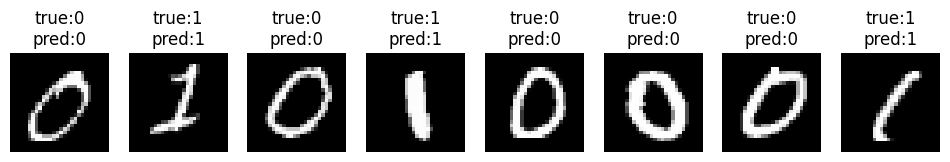

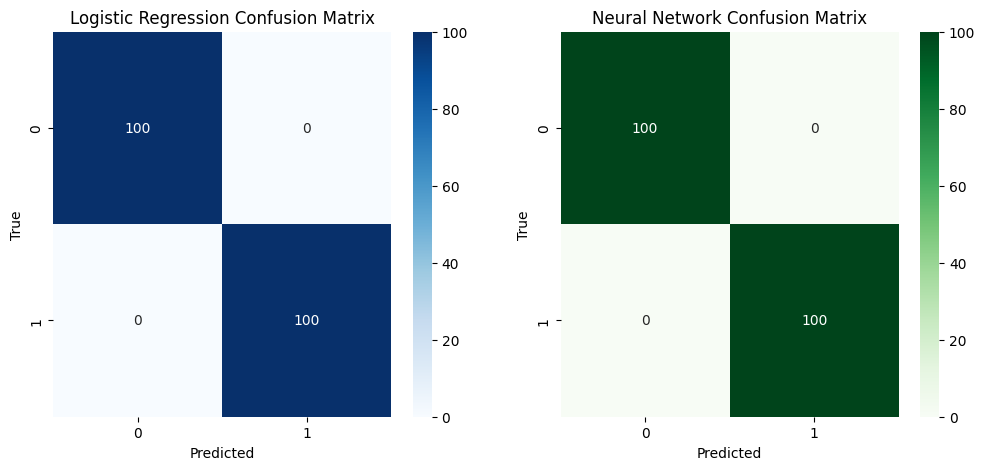

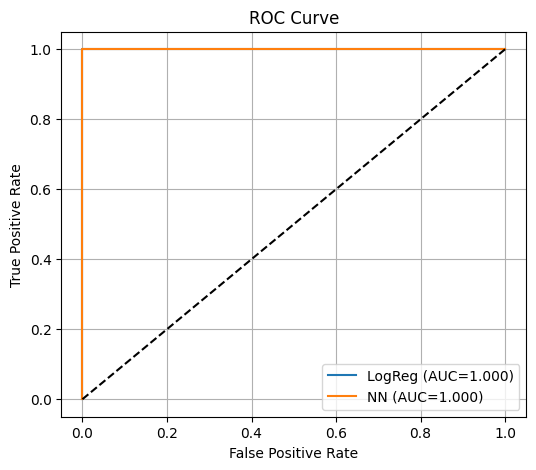

In [39]:
# Cell 8 — Plots: some test images, confusion matrices, ROC curves
def show_images(X, y_true, y_pred=None, n=8):
    plt.figure(figsize=(12,3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(X[i], cmap='gray')
        title = f"true:{y_true[i]}"
        if y_pred is not None:
            title += f"\npred:{y_pred[i]}"
        plt.title(title)
        plt.axis('off')
    plt.show()

# Show first 8 test images with NN predictions
show_images(X_test, y_test_bin, y_pred_nn, n=8)

# Confusion matrices (heatmaps)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1,2,2)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Greens')
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC curves
plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={auc_lr:.3f})')
plt.plot(fpr_nn, tpr_nn, label=f'NN (AUC={auc_nn:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


In [40]:
# Cell 9 — Save model & results optional (if you want to keep artifacts in Colab)
# Save Keras model
model.save("mnist_binary_nn.h5")
print("Saved model to mnist_binary_nn.h5")

# Save the logistic regression via joblib
import joblib
joblib.dump(clf, "mnist_logreg.joblib")
print("Saved logistic regression to mnist_logreg.joblib")


Saved model to mnist_binary_nn.h5
Saved logistic regression to mnist_logreg.joblib


In [41]:
# Cell 10 — Show misclassified examples (for Neural Network model)
mis_idx = np.where(y_pred_nn != y_test_bin)[0]
print(f"Total misclassified examples: {len(mis_idx)}")

if len(mis_idx) > 0:
    n_show = min(10, len(mis_idx))
    plt.figure(figsize=(12,3))
    for i in range(n_show):
        idx = mis_idx[i]
        plt.subplot(1, n_show, i+1)
        plt.imshow(X_test[idx], cmap='gray')
        plt.title(f"True:{y_test_bin[idx]}, Pred:{y_pred_nn[idx]}")
        plt.axis('off')
    plt.suptitle("Some Misclassified Images (Neural Net)")
    plt.show()
else:
    print("No misclassifications — model is perfect on test set!")


Total misclassified examples: 0
No misclassifications — model is perfect on test set!


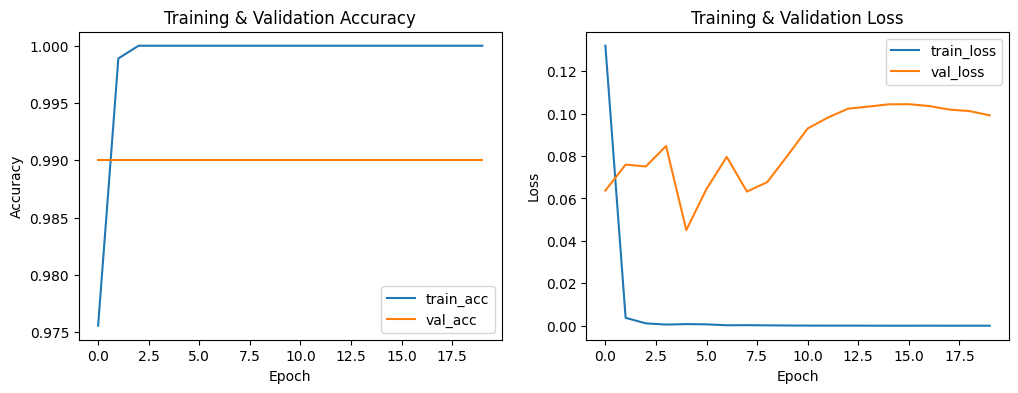

In [42]:
# Cell 11 — Training history plots for the Neural Network
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


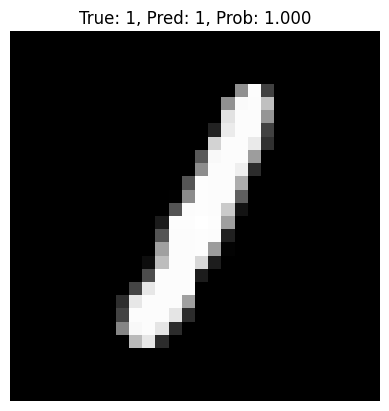

In [43]:
# Cell 12 — Predict a random test image
rand_idx = np.random.randint(0, len(X_test))
img = X_test[rand_idx]
true_label = y_test_bin[rand_idx]
pred_prob = model.predict(img.reshape(1, -1).astype("float32") / 255.0)[0][0]
pred_label = int(pred_prob >= 0.5)

plt.imshow(img, cmap='gray')
plt.title(f"True: {true_label}, Pred: {pred_label}, Prob: {pred_prob:.3f}")
plt.axis('off')
plt.show()


Performance comparison:



,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,1.0,1.0,1.0,1.0,1.0
1,Neural Network,1.0,1.0,1.0,1.0,1.0


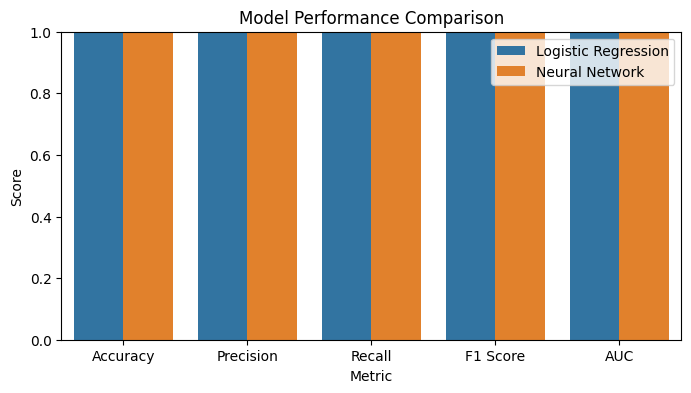

In [44]:
# Cell 13 — Compare both models side-by-side
import pandas as pd

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Neural Network'],
    'Accuracy': [acc_lr, acc_nn],
    'Precision': [prec_lr, prec_nn],
    'Recall': [recall_lr, recall_nn],
    'F1 Score': [f1_lr, f1_nn],
    'AUC': [auc_lr, auc_nn]
})

print("Performance comparison:\n")
display(results)

plt.figure(figsize=(8,4))
sns.barplot(data=results.melt(id_vars="Model", var_name="Metric", value_name="Score"),
            x="Metric", y="Score", hue="Model")
plt.title("Model Performance Comparison")
plt.ylim(0,1)
plt.legend()
plt.show()


In [45]:
# Cell 14 — Save metrics summary to a .txt file
with open("mnist_results_summary.txt", "w") as f:
    f.write("=== Logistic Regression ===\n")
    f.write(f"Accuracy: {acc_lr:.4f}, Precision: {prec_lr:.4f}, Recall: {recall_lr:.4f}, F1: {f1_lr:.4f}, AUC: {auc_lr:.4f}\n\n")

    f.write("=== Neural Network ===\n")
    f.write(f"Accuracy: {acc_nn:.4f}, Precision: {prec_nn:.4f}, Recall: {recall_nn:.4f}, F1: {f1_nn:.4f}, AUC: {auc_nn:.4f}\n\n")

    f.write("Confusion Matrix (NN):\n")
    f.write(np.array2string(cm_nn))
    f.write("\n\nClassification Report (NN):\n")
    f.write(classification_report(y_test_bin, y_pred_nn, target_names=[str(digit_a), str(digit_b)]))

print("✅ Results saved to mnist_results_summary.txt (you can download from Colab).")


✅ Results saved to mnist_results_summary.txt (you can download from Colab).
